##### This notebook creates STDNN-SE (pytorch) for classification prediction on Tox21

Using split data already saved.

Notebook shows results for seed = 124, but we also ran on seed 122, 123. 

Before use define desired pathways to save models,:
- path variable, in "Create checkpoint" section for models
- writer variable, in "Train the neural network model" section for tensorboard summary

In [47]:
# general and data handling
import numpy as np
import pandas as pd
import os
from collections import Counter

# Required RDKit modules
import rdkit as rd
from rdkit import DataStructs
from rdkit.Chem import AllChem

# modeling
import sklearn as sk
from sklearn.model_selection import train_test_split

# Graphing
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
import time
import random
import joblib

In [49]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [50]:
import torch
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  
print(device)

cpu


In [51]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [52]:
# Ensure runs on GPU
import tensorflow as tf
import datetime, os

##### Settings

In [53]:
# set seed value
seed_value = 124 #122 123 124, as used in MoleculeNet
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)
torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic=True

In [54]:
# number of bits for morgan fingerprints
morgan_bits = 4096

In [55]:
# number of radius for morgan fingerprints
morgan_radius = 2

In [56]:
train_epoch = 50 

In [57]:
batch = 512 

##### Load raw data

In [58]:
tox21_file  = '../../../../data/datasets/tox21/raw_data/tox21.csv'
tox21_tasks = ['NR-AR', 'NR-Aromatase', 'NR-PPAR-gamma', 'SR-HSE', 
               'NR-AR-LBD', 'NR-ER', 'SR-ARE', 'SR-MMP',
               'NR-AhR', 'NR-ER-LBD', 'SR-ATAD5', 'SR-p53']

tox21_data = pd.read_csv(tox21_file)
print('Reading {}... {} data loaded.'.format(tox21_file, len(tox21_data)))
tox21_data.head()

Reading ../../../../data/datasets/tox21/raw_data/tox21.csv... 8014 data loaded.


,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,TOX3028,CC(O)(P(=O)(O)O)P(=O)(O)O


#####  Setting all tasks 

In [59]:
data = [tox21_data] 

In [60]:
all_tasks = tox21_tasks 

##### Load split data

In [61]:
# load saved tox21 train/test/valid data 
data_path = "../../../../data/datasets/tox21/split_data/seed_124/"
train_data=torch.load(data_path + 'train_data_tox21.pth')
test_data=torch.load(data_path + 'test_data_tox21.pth')
valid_data=torch.load(data_path + 'valid_data_tox21.pth')

data = [train_data, test_data, valid_data]

In [62]:
print("Total number of examples, train: " + str(data[0].shape[0]))
print("Total number of examples, test: " + str(data[1].shape[0]))
print("Total number of examples, valid: " + str(data[2].shape[0]))
print("Total number of examples, train+test+valid: " + str(data[0].shape[0] + data[1].shape[0] + data[2].shape[0]))

Total number of examples, train: 6411
Total number of examples, test: 801
Total number of examples, valid: 802
Total number of examples, train+test+valid: 8014


##### SMILES embedding featurization 

In [63]:
# Load existing SE featurization - dictionary of SMILES embedding given a SMILES
smiles_embed = torch.load("../../../../data/smiles_embedding/toxicity_smiles.pt")

In [64]:
# Obtain SMILES Embedding for given SMILES 
for i in range(len(data)):
    data[i]['smiles_embed'] = data[i]['smiles'].apply(lambda x: smiles_embed.get(x))

In [65]:
# Check if any NA 
sum = 0 
for i in range(len(data)):
    na = data[i]['smiles_embed'].isna().sum()
    sum = sum + na
print(sum)

0


##### Create train, test, valid sets

In [66]:
# replace NA with -1 -- used to deal with missing labels, 
#                       along with Binary Cross-Entropy loss
data[0] = data[0].fillna(-1)
data[1] = data[1].fillna(-1)
data[2] = data[2].fillna(-1)

In [67]:
train_data = data[0]
test_data  = data[1]
valid_data = data[2]

In [68]:
## Arrays for train / test / valid sets used for DNN 
# convert column with embedding to array
x_train = []
for tensor in train_data['smiles_embed']:
    x_train.append(tensor)

x_train = torch.stack(x_train)
x_train = x_train.numpy()

y_train = train_data[all_tasks].values

In [69]:
# convert column with embedding to array
x_test = []

for tensor in test_data['smiles_embed']:
    x_test.append(tensor)
x_test = torch.stack(x_test)
x_test = x_test.numpy()

y_test = test_data[all_tasks].values

In [70]:
# convert column with embedding to array
x_valid = []
for tensor in valid_data['smiles_embed']:
    x_valid.append(tensor)
x_valid = torch.stack(x_valid)
x_valid = x_valid.numpy()

    
y_valid = valid_data[all_tasks].values

In [71]:
# count the number of data points per class
N_train = np.sum(y_train >= 0, 0)
N_test  = np.sum(y_test >= 0, 0)
N_valid  = np.sum(y_valid >= 0, 0)

##### Deep Neural Network (pytorch)

In [72]:
import torch
from torch.utils.data import Dataset, DataLoader

In [73]:
# convert data for pytorch
x_train_torch = x_train.astype(np.float32)
y_train_torch = y_train.astype(np.float32)

x_test_torch = x_test.astype(np.float32)
y_test_torch = y_test.astype(np.float32)

x_valid_torch = x_valid.astype(np.float32)
y_valid_torch = y_valid.astype(np.float32)

In [74]:
input_shape = x_train_torch.shape[1]
input_shape

128

In [75]:
# Class for STDNN data
class STDNNData(Dataset):

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [76]:
training_set = STDNNData(x_train_torch, y_train_torch)
training_generator = DataLoader(training_set, batch_size=batch, shuffle=True)

testing_set = STDNNData(x_test_torch, y_test_torch)
testing_generator = DataLoader(testing_set, batch_size=len(testing_set), shuffle=False)

valid_set = STDNNData(x_valid_torch, y_valid_torch)
valid_generator = DataLoader(valid_set, batch_size=len(valid_set), shuffle=False)

In [77]:
# DNN Model class
# Each 12 tasks are treated as separate tasks with 2 separate layers
class DNN(torch.nn.Module):
    def __init__(self, input_shape, all_tasks):
        super(DNN, self).__init__()

        self.hidden_1 = torch.nn.ModuleList([torch.nn.Linear(input_shape, 1024) for task in all_tasks])
        self.batchnorm_1 = torch.nn.ModuleList([torch.nn.BatchNorm1d(1024) for task in all_tasks])
        self.dropout_1 = torch.nn.ModuleList([torch.nn.Dropout(0.5) for task in all_tasks])
        
        self.hidden_2 = torch.nn.ModuleList([torch.nn.Linear(1024, 512) for task in all_tasks])
        self.batchnorm_2 = torch.nn.ModuleList([torch.nn.BatchNorm1d(512) for task in all_tasks])
        self.dropout_2 = torch.nn.ModuleList([torch.nn.Dropout(0.5) for task in all_tasks])
        
        self.output   = torch.nn.ModuleList([torch.nn.Linear(512, 1) for task in all_tasks])
        
        # function for leaky ReLU
        self.leakyReLU = torch.nn.LeakyReLU(0.05)

    def forward(self, x):        
        x_task = [None for i in range(len(self.output))]  # initialize
        for task in range(len(self.output)):
            x_task[task] = self.hidden_1[task](x)
            x_task[task] = self.batchnorm_1[task](x_task[task])
            x_task[task] = self.leakyReLU(x_task[task])
            x_task[task] = self.dropout_1[task](x_task[task])
            
            x_task[task] = self.hidden_2[task](x_task[task])
            x_task[task] = self.batchnorm_2[task](x_task[task])
            x_task[task] = self.leakyReLU(x_task[task])
            x_task[task] = self.dropout_2[task](x_task[task])
            
            x_task[task] = self.output[task](x_task[task])
            x_task[task] = torch.sigmoid(x_task[task])
        
        y_pred = x_task
        
        return y_pred
    
model = DNN(input_shape, all_tasks).to(device)

##### Create checkpoint - saving and loading best model 

In [78]:
## Method from : https://gist.github.com/vsay01/45dfced69687077be53dbdd4987b6b17

import shutil
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

In [79]:
def load_ckp(checkpoint_fpath, input_model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    input_model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    train_loss_min = checkpoint['train_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], train_loss_min.item()

In [80]:
###### Pathways to save models 
checkpoint_path = 'current_checkpoint.pt'

#Path to saved model when train_epoch_loss <= train_loss_min
bestmodel_path = 'best_model.pt'  

#Path to saved model at minimum valid loss
bestmodel_byvalid = 'best_model_by_valid.pt' 

#Path to saved  when train_epoch_loss >= val_epoch_loss
bestmodel_byvalid_crossed = 'best_model_by_valid-crossed.pt'   

##### Train the neural network model

In [81]:
# Define the loss
criterion = torch.nn.BCELoss()

# Optimizers require the parameters to optimize and a learning rate
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [82]:
from torch.utils.tensorboard import SummaryWriter

# Define the desired pathway
writer = SummaryWriter('define-pathway/')

In [83]:
%%time
##################### With Tensorboard ######################
loss_history=[]  
correct_history=[]  
val_loss_history=[]  
val_correct_history=[] 
train_loss_min = np.Inf
val_loss_min = np.Inf


# Training
for e in range(train_epoch):
    
    model.train()
    # keep track of the loss over an epoch
    running_train_loss = 0
    running_valid_loss = 0
    running_train_correct = 0
    running_val_correct = 0
    y_train_true = []
    y_train_pred = []
    y_valid_true = []
    y_valid_pred = []
    batch_num = 0
    for x_batch, y_batch in training_generator:
        batch_num += 1
        if torch.cuda.is_available():
            x_batch, y_batch = x_batch.cuda(), y_batch.cuda() 
        
        # Forward pass: Compute predicted y by passing x to the model
        y_pred = model(x_batch)  # for all tasks
        
        # Compute loss over all tasks
        loss = 0
        correct = 0
        y_train_true_task = []
        y_train_pred_task = []
        for i in range(len(all_tasks)):
            y_batch_task = y_batch[:,i]
            y_pred_task  = y_pred[i][:,0] #check if predictions na
            
            # compute loss for labels that are not NA
            indice_valid = y_batch_task >= 0
            loss_task = criterion(y_pred_task[indice_valid], y_batch_task[indice_valid]) / N_train[i]
            
            loss += loss_task

            pred_train = np.round(y_pred_task[indice_valid].detach().cpu().numpy())
            target_train = y_batch_task[indice_valid].float()
            y_train_true.extend(target_train.tolist()) 
            y_train_pred.extend(pred_train.reshape(-1).tolist())

        # Zero gradients, perform a backward pass, and update the weights.
        writer.add_scalar("Accuracy/train", loss, batch_num)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        # sum up the losses from each batch
        running_train_loss += loss.item()
        writer.add_scalar("Loss/train", running_train_loss, e)
        
    else:
        with torch.no_grad():    
        ## evaluation part 
            model.eval()
            for val_x_batch, val_y_batch in valid_generator:
                
                if torch.cuda.is_available():
                    val_x_batch, val_y_batch = val_x_batch.cuda(), val_y_batch.cuda() 
                
                val_output = model(val_x_batch)

                ## 2. loss calculation over all tasks 
                val_loss = 0
                val_correct = 0
                y_valid_true_task = []
                y_valid_pred_task = []
                for i in range(len(all_tasks)):
                    val_y_batch_task = val_y_batch[:,i]
                    val_output_task  = val_output[i][:,0]

                    # compute loss for labels that are not NA
                    indice_valid = val_y_batch_task >= 0
                    val_loss_task = criterion(val_output_task[indice_valid], val_y_batch_task[indice_valid]) / N_valid[i]

                    val_loss += val_loss_task
                    
                    pred_valid = np.round(val_output_task[indice_valid].detach().cpu().numpy())
                    target_valid = val_y_batch_task[indice_valid].float()
                    y_valid_true.extend(target_valid.tolist()) 
                    y_valid_pred.extend(pred_valid.reshape(-1).tolist())
                

                running_valid_loss+=val_loss.item()
                writer.add_scalar("Loss/valid", running_valid_loss, e)
        
        #epoch loss
        train_epoch_loss=np.mean(running_train_loss)
        val_epoch_loss=np.mean(running_valid_loss)  
       
        #epoch accuracy      
        train_epoch_acc = accuracy_score(y_train_true,y_train_pred)
        val_epoch_acc = accuracy_score(y_valid_true,y_valid_pred)
        
        #history
        loss_history.append(train_epoch_loss)  
        correct_history.append(train_epoch_acc)
        val_loss_history.append(val_epoch_loss)  
        val_correct_history.append(val_epoch_acc)  
        
        print("Epoch:", e, "Training Loss:", train_epoch_loss, "Valid Loss:", val_epoch_loss)
        print("Training Acc:", train_epoch_acc, "Valid Acc:", val_epoch_acc)
        
        # create checkpoint variable and add important data
        checkpoint = {
            'epoch': e + 1,
            'train_loss_min': train_epoch_loss,
            'val_loss_min': val_epoch_loss, 
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        
        # save checkpoint
        save_ckp(checkpoint, False, checkpoint_path, bestmodel_path)
        
        ## TODO: save the model if validation loss has decreased
        if train_epoch_loss <= train_loss_min:
            print('Training loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(train_loss_min,train_epoch_loss))
            # save checkpoint as best model
            save_ckp(checkpoint, True, checkpoint_path, bestmodel_path)
            train_loss_min = train_epoch_loss
            
        if train_epoch_loss >= val_epoch_loss:
            print('Training loss greater than validation loss ({:.6f} --> {:.6f}).  Saving model ...'.format(train_epoch_loss,val_epoch_loss))
            # save checkpoint as best model
            save_ckp(checkpoint, True, checkpoint_path, bestmodel_byvalid_crossed)
            train_loss_min = train_epoch_loss
            
        if val_epoch_loss <= val_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(val_loss_min,val_epoch_loss))
            # save checkpoint as best model
            save_ckp(checkpoint, True, checkpoint_path, bestmodel_byvalid)
            val_loss_min = val_epoch_loss

Epoch: 0 Training Loss: 0.011990078492090106 Valid Loss: 0.00710315490141511
Training Acc: 0.8337476791389999 Valid Acc: 0.9247298316159839
Training loss decreased (inf --> 0.011990).  Saving model ...
Training loss greater than validation loss (0.011990 --> 0.007103).  Saving model ...
Validation loss decreased (inf --> 0.007103). Saving model ...
Epoch: 1 Training Loss: 0.006202418764587492 Valid Loss: 0.004365915898233652
Training Acc: 0.935251911760078 Valid Acc: 0.9295049007288263
Training loss decreased (0.011990 --> 0.006202).  Saving model ...
Training loss greater than validation loss (0.006202 --> 0.004366).  Saving model ...
Validation loss decreased (0.007103 --> 0.004366). Saving model ...
Epoch: 2 Training Loss: 0.005515859491424635 Valid Loss: 0.003976108506321907
Training Acc: 0.9383359033263052 Valid Acc: 0.9279969841668761
Training loss decreased (0.006202 --> 0.005516).  Saving model ...
Training loss greater than validation loss (0.005516 --> 0.003976).  Saving mode

In [84]:
# Loads model at lowest validation loss 
loaded_model, optimizer, start_epoch, train_loss_min = load_ckp(bestmodel_byvalid, model, optimizer)

##### Evaluate on test set

In [85]:
# print test loss
for x_test_torch, y_test_torch in testing_generator:
    y_test_pred = model.eval().to(device).cpu()(x_test_torch)
    
    # Compute loss over all tasks
    loss = 0
    for i in range(len(all_tasks)):
        y_test_task = y_test_torch[:,i]
        y_pred_task  = y_test_pred[i][:,0]

        # compute loss for labels that are not NA
        indice_valid = y_test_task >= 0
        loss_task = criterion(y_pred_task[indice_valid], y_test_task[indice_valid]) / N_test[i]

        loss += loss_task
    
print(loss.item())

0.0035271646920591593


Accuracy for STDNN on SMILES Embeddings: 0.9745649263721553
F1 for STDNN on SMILES Embeddings: 0.5777777777777778
 True Positive: 0.43333333333333335
 True Negative: 0.99721059972106
False Positive: 0.002789400278940028
False Negative: 0.5666666666666667
Test ROC AUC (NR-AR): 0.7710832171083216


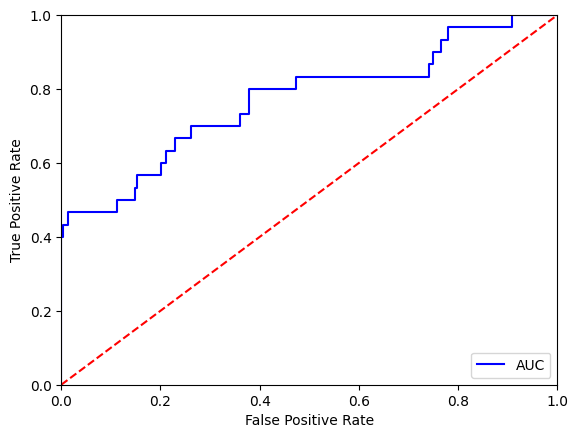

Accuracy for STDNN on SMILES Embeddings: 0.9446308724832215
F1 for STDNN on SMILES Embeddings: 0.326530612244898
 True Positive: 0.23529411764705882
 True Negative: 0.9875444839857651
False Positive: 0.012455516014234875
False Negative: 0.7647058823529411
Test ROC AUC (NR-Aromatase): 0.8947037889889051


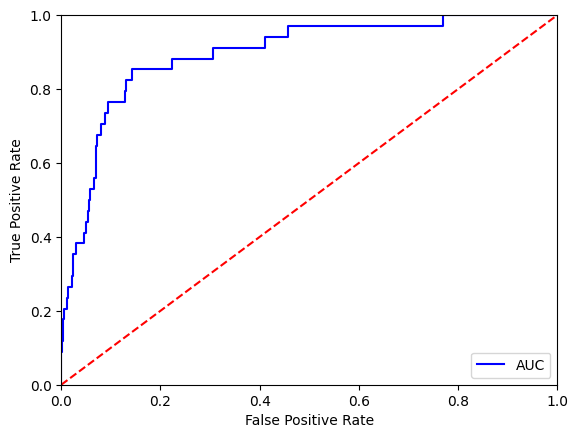

Accuracy for STDNN on SMILES Embeddings: 0.9791976225854383
F1 for STDNN on SMILES Embeddings: 0.125
 True Positive: 0.07142857142857142
 True Negative: 0.9984825493171472
False Positive: 0.0015174506828528073
False Negative: 0.9285714285714286
Test ROC AUC (NR-PPAR-gamma): 0.6029698677650119


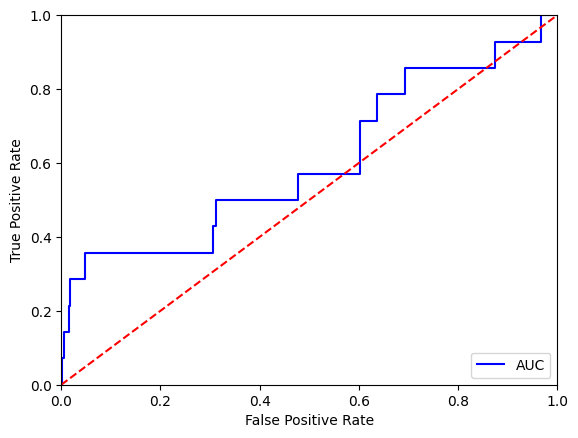

Accuracy for STDNN on SMILES Embeddings: 0.9525925925925925
F1 for STDNN on SMILES Embeddings: 0.40740740740740744
 True Positive: 0.3055555555555556
 True Negative: 0.9890453834115805
False Positive: 0.010954616588419406
False Negative: 0.6944444444444444
Test ROC AUC (SR-HSE): 0.8417231785776387


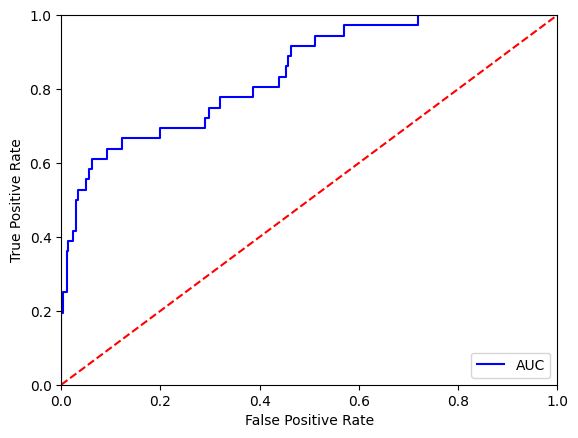

Accuracy for STDNN on SMILES Embeddings: 0.9886845827439887
F1 for STDNN on SMILES Embeddings: 0.7500000000000001
 True Positive: 0.7058823529411765
 True Negative: 0.9956521739130435
False Positive: 0.004347826086956522
False Negative: 0.29411764705882354
Test ROC AUC (NR-AR-LBD): 0.8541346973572037


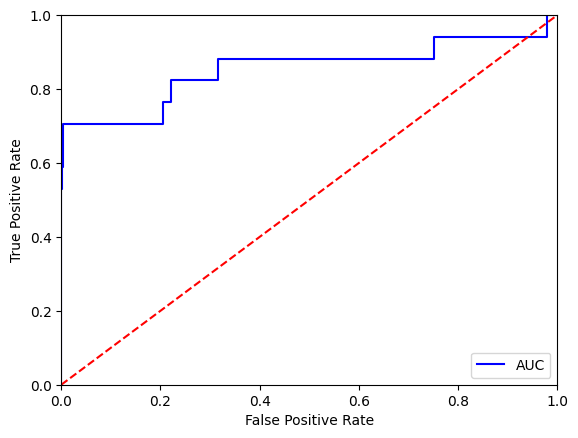

Accuracy for STDNN on SMILES Embeddings: 0.877488514548239
F1 for STDNN on SMILES Embeddings: 0.4117647058823529
 True Positive: 0.28865979381443296
 True Negative: 0.9802158273381295
False Positive: 0.019784172661870502
False Negative: 0.711340206185567
Test ROC AUC (NR-ER): 0.7349625454275754


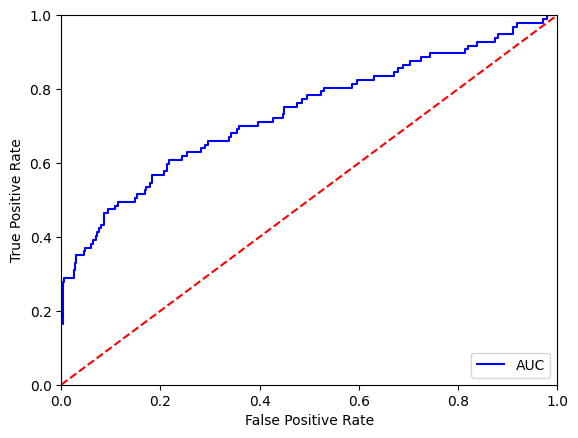

Accuracy for STDNN on SMILES Embeddings: 0.8469387755102041
F1 for STDNN on SMILES Embeddings: 0.4375
 True Positive: 0.3645833333333333
 True Negative: 0.9410569105691057
False Positive: 0.05894308943089431
False Negative: 0.6354166666666666
Test ROC AUC (SR-ARE): 0.8135374322493226


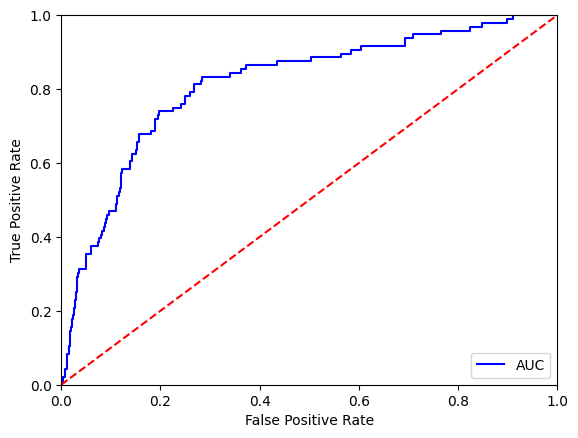

Accuracy for STDNN on SMILES Embeddings: 0.8849407783417935
F1 for STDNN on SMILES Embeddings: 0.6421052631578947
 True Positive: 0.6421052631578947
 True Negative: 0.9314516129032258
False Positive: 0.06854838709677419
False Negative: 0.35789473684210527
Test ROC AUC (SR-MMP): 0.892062818336163


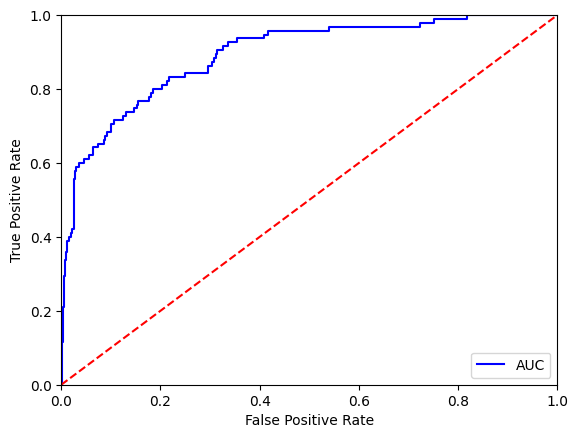

Accuracy for STDNN on SMILES Embeddings: 0.9172821270310192
F1 for STDNN on SMILES Embeddings: 0.6056338028169015
 True Positive: 0.5375
 True Negative: 0.9681742043551089
False Positive: 0.031825795644891124
False Negative: 0.4625
Test ROC AUC (NR-AhR): 0.9192839195979899


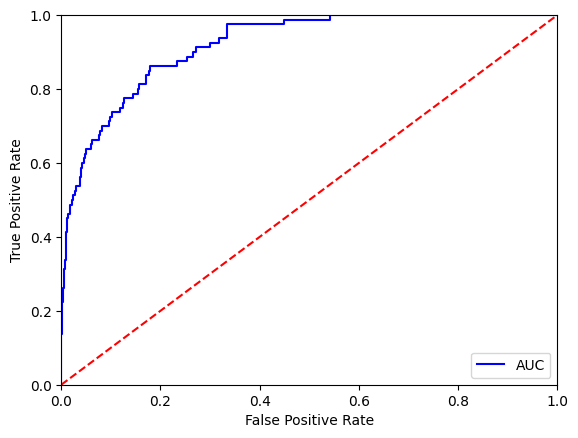

Accuracy for STDNN on SMILES Embeddings: 0.9598893499308437
F1 for STDNN on SMILES Embeddings: 0.6027397260273972
 True Positive: 0.5
 True Negative: 0.9896907216494846
False Positive: 0.010309278350515464
False Negative: 0.5
Test ROC AUC (NR-ER-LBD): 0.896539027982327


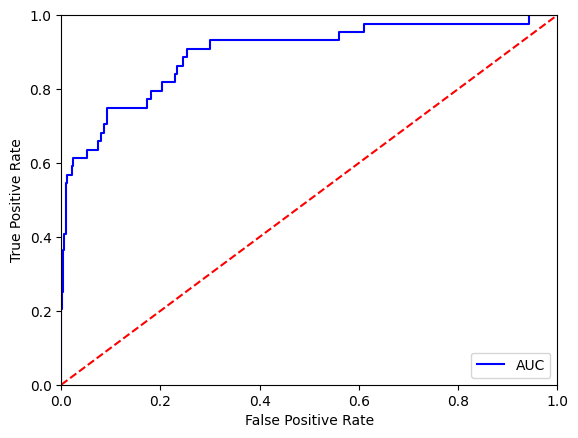

Accuracy for STDNN on SMILES Embeddings: 0.9701897018970189
F1 for STDNN on SMILES Embeddings: 0.26666666666666666
 True Positive: 0.16666666666666666
 True Negative: 0.9971988795518207
False Positive: 0.0028011204481792717
False Negative: 0.8333333333333334
Test ROC AUC (SR-ATAD5): 0.8040966386554622


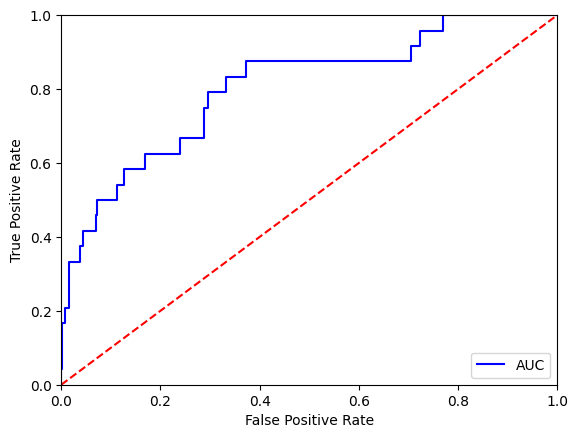

Accuracy for STDNN on SMILES Embeddings: 0.9393939393939394
F1 for STDNN on SMILES Embeddings: 0.27586206896551724
 True Positive: 0.17777777777777778
 True Negative: 0.9922839506172839
False Positive: 0.007716049382716049
False Negative: 0.8222222222222222
Test ROC AUC (SR-p53): 0.8427297668038409


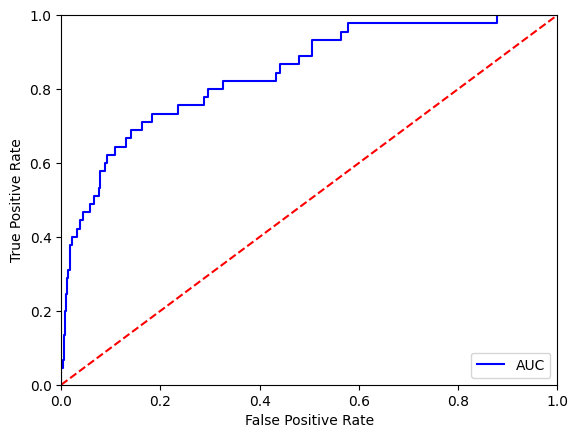

In [86]:
results = {}
# Collects performance metrics for all tasks on test set
for i in range(len(all_tasks)):
    
    valid_datapoints = y_test[:,i] >= 0
    y_test_task = y_test[valid_datapoints,i] 
    y_test_pred_task = y_test_pred[i].detach().numpy()[valid_datapoints,0]
    
    acc = accuracy_score(y_test_task, np.round(y_test_pred_task))
    print('Accuracy for STDNN on SMILES Embeddings:', acc)
    
    bacc = sk.metrics.balanced_accuracy_score(y_test_task, np.round(y_test_pred_task))

    f1 = f1_score(y_test_task, np.round(y_test_pred_task), pos_label=1)
    print('F1 for STDNN on SMILES Embeddings:', f1)

    cfm = sk.metrics.confusion_matrix(y_test_task, np.round(y_test_pred_task))
    cfm = cfm.astype('float') / cfm.sum(axis=1)[:, np.newaxis]

    tn, fp, fn, tp = cfm.ravel()
    pr = tp / (tp + fp)
    rc = tp / (tp + fn)
    print(' True Positive:', tp)
    print(' True Negative:', tn)
    print('False Positive:', fp)
    print('False Negative:', fn)
    
    
    auc = roc_auc_score(y_test_task, y_test_pred_task)
    print('Test ROC AUC ({}):'.format(all_tasks[i]), auc)
    
    results[all_tasks[i]] = [auc, acc, bacc, tn, tp, pr, rc, f1]

    fpr, tpr, threshold = sk.metrics.roc_curve(y_test_task, y_test_pred_task)
    plt.plot(fpr, tpr, 'b', label = 'AUC')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [87]:
print('Task'.ljust(10), '\t', '  AUC ', ' ACC ', ' BACC ', ' TN  ', ' TP  ', ' PR  ', ' RC  ', ' F1  ')
for task, auc in results.items():
    print(task.ljust(10), '\t', np.round(auc,3))

Task       	   AUC   ACC   BACC   TN    TP    PR    RC    F1  
NR-AR      	 [0.771 0.975 0.715 0.997 0.433 0.994 0.433 0.578]
NR-Aromatase 	 [0.895 0.945 0.611 0.988 0.235 0.95  0.235 0.327]
NR-PPAR-gamma 	 [0.603 0.979 0.535 0.998 0.071 0.979 0.071 0.125]
SR-HSE     	 [0.842 0.953 0.647 0.989 0.306 0.965 0.306 0.407]
NR-AR-LBD  	 [0.854 0.989 0.851 0.996 0.706 0.994 0.706 0.75 ]
NR-ER      	 [0.735 0.877 0.634 0.98  0.289 0.936 0.289 0.412]
SR-ARE     	 [0.814 0.847 0.653 0.941 0.365 0.861 0.365 0.438]
SR-MMP     	 [0.892 0.885 0.787 0.931 0.642 0.904 0.642 0.642]
NR-AhR     	 [0.919 0.917 0.753 0.968 0.538 0.944 0.538 0.606]
NR-ER-LBD  	 [0.897 0.96  0.745 0.99  0.5   0.98  0.5   0.603]
SR-ATAD5   	 [0.804 0.97  0.582 0.997 0.167 0.983 0.167 0.267]
SR-p53     	 [0.843 0.939 0.585 0.992 0.178 0.958 0.178 0.276]
